## Задание

#### 1. Линейная регрессия
1. Разработать модель линейной регрессии, учитывающей все (в примере), 2, 3 столбца входных переменных.
2. Рассчитать MSE.
3. Вывести значения коэффициентов модели.

#### 2. [Полиномиальная регрессия](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
1. Разработать модель линейной регрессии, базисные функции - полином от исходных значений.
2. Найти зависимость MSE от максимальной степени полинома. (max_pow <= 10)

#### 3. [Гребневая регрессия (Ridge)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
1. Выбрать оптимальную степень полинома.
2. Построить график зависимости максимального модуля параметров, MSE от величины alpha.

#### 4. [Лассо](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
1. Выбрать оптимальную степень полинома.
2. Построить график зависимости максимального модуля параметров, MSE от величины alpha.



#### 5. [SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html#sklearn.svm.SVR)
1. Исследовать точность модели регрессии при применении ядерных функций 'poly', 'sigmoid'
2. Реализовать модель SVR, учитывающую все характеристики исходных данных, выбрать модель с оптимальными параметрами.

## Решение

### Импорт

In [73]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.preprocessing import MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import ParameterGrid, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import os

### Настройки

In [74]:
RANDOM_STATE = 42

# Папка лабораторной
DIR_LAB = 'Lab5'

# Папка для загруженных данных
DIR_DATA = 'data'

# Файл с данными
FILE_DATA = 'Advertising.csv'

In [75]:
PATH_DATA = os.path.join(DIR_LAB, DIR_DATA, FILE_DATA)

### Функции

##### Функция тестирования

In [76]:
def tests_results_former(pipeline, score, **params):
    return score

def run_tests(pipeline, params_grid, X_train, X_test, y_train, y_test, results_former=tests_results_former):
    results = []

    for params in params_grid:
        pipeline.set_params(**params)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        score = mean_squared_error(y_test, y_pred)

        results.append(results_former(pipeline, score, **params))

    return results

In [77]:
def run_tests_select(pipeline, params_grid_select, params_grid, X_train, X_test, y_train, y_test, results_former=tests_results_former):
    best_results = []
    best_params = None
    best_score = float('inf')

    for params_select in params_grid_select:
        pipeline.set_params(**params_select)

        results = []
        scores = []

        for params in params_grid:
            pipeline.set_params(**params)

            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)

            score = mean_squared_error(y_test, y_pred)

            results.append(results_former(pipeline, score, **params, **params_select))
            scores.append(score)

        mean_score = np.mean(scores)

        if (mean_score < best_score):
            best_results = results
            best_params = params_select
            best_score = mean_score

    return best_params, best_score, best_results

In [78]:
def run_tests_optimize(pipeline, params_grid, params_grid_optimize, X_train, X_test, y_train, y_test, results_former=tests_results_former):
    results = []
    
    best_params = None
    best_score = float('inf')

    for params in params_grid:
        pipeline.set_params(**params)

        grid_search = GridSearchCV(pipeline, params_grid_optimize, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)

        pipeline.set_params(**grid_search.best_params_)

        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)

        score = mean_squared_error(y_test, y_pred)

        results.append(results_former(pipeline, score, **params, **grid_search.best_params_))

        if (score < best_score):
            best_params = {**params, **grid_search.best_params_}
            best_score = score

    return best_params, best_score, results

##### Извлечение столбцов

In [79]:
class ColumnExtractor(BaseEstimator):
    def __init__(self, columns=np.array([0])):
        self.columns = columns

    def transform(self, X):
        cols = X[:, self.columns]
        return cols

    def fit(self, X, y=None):
        return self

### Загрузка данных

In [80]:
df_data = pd.read_csv(PATH_DATA, index_col='Unnamed: 0')
df_data.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


<Axes: >

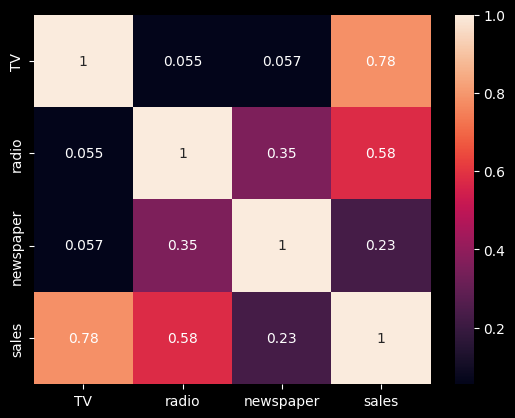

In [81]:
sns.heatmap(df_data.corr(),annot=True)

In [82]:
X = df_data[['TV', 'radio', 'newspaper']].to_numpy()
y = df_data['sales'].to_numpy()

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

### 1. Линейная регрессия

In [84]:
def linear_results_former(pipeline, score, **params):
    return (len(params['columns__columns']), ' '.join([f'{coef:.10f}' for coef in pipeline['linear'].coef_]), pipeline['linear'].intercept_, score)

In [85]:
linear_pipeline = Pipeline([('scaler', MaxAbsScaler()), ('columns', ColumnExtractor()), ('linear', LinearRegression())])

linear_params = ParameterGrid({'columns__columns': [np.arange(0, i + 1) for i in range(3)]})

linear_results = run_tests(linear_pipeline, linear_params, X_train, X_test, y_train, y_test, results_former=linear_results_former)

In [86]:
df_linear_results = pd.DataFrame(linear_results, columns=['Количество параметров', 'Коэффициенты', 'Перехват', 'MSE'])

df_linear_results

,Количество параметров,Коэффициенты,Перехват,MSE
0,1,13.8995166792,7.131785,9.179299
1,2,13.4663890192 9.5639278285,2.824519,2.853995
2,3,13.4665067763 9.4962441666 0.2591203633,2.778303,2.880024


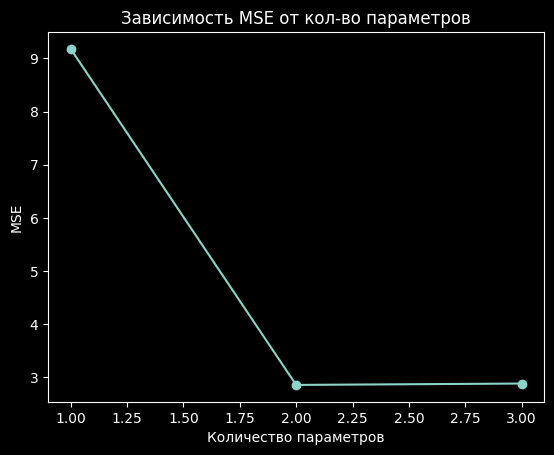

In [87]:
plt.plot(df_linear_results['Количество параметров'], df_linear_results['MSE'], marker='o')
plt.xlabel('Количество параметров')
plt.ylabel('MSE')
plt.title('Зависимость MSE от кол-во параметров')
plt.show()

### 2. Полиномиальная регрессия

In [88]:
def poly_results_former(pipeline, score, **params):
    return (params['poly__degree'], score)

In [89]:
poly_pipeline = Pipeline([('scaler', MaxAbsScaler()), ('poly', PolynomialFeatures()), ('linear', LinearRegression())])

poly_params = ParameterGrid({'poly__degree': np.arange(1, 10 + 1)})

poly_results = run_tests(poly_pipeline, poly_params, X_train, X_test, y_train, y_test, results_former=poly_results_former)

In [90]:
df_poly_results = pd.DataFrame(poly_results, columns=['Степень полинома', 'MSE'])

df_poly_results

,Степень полинома,MSE
0,1,2.880024e+00
1,2,3.910578e-01
2,3,2.457018e-01
3,4,2.778726e-01
4,5,7.819255e+01
5,6,3.280100e+02
6,7,1.199494e+05
7,8,2.644808e+06
8,9,2.985741e+06
9,10,5.608481e+06


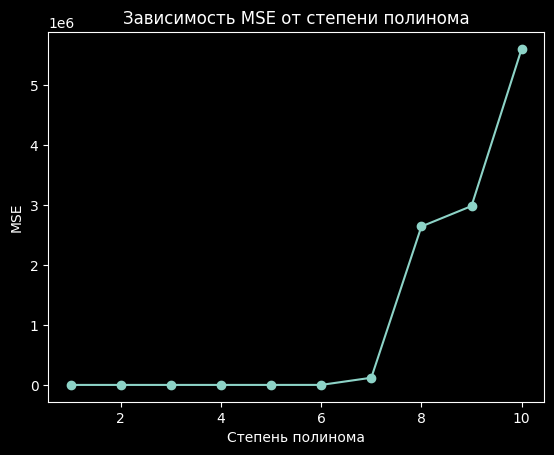

In [91]:
plt.plot(df_poly_results['Степень полинома'], df_poly_results['MSE'], marker='o')
plt.xlabel('Степень полинома')
plt.ylabel('MSE')
plt.title('Зависимость MSE от степени полинома')
plt.show()

### 3. Гребневая регрессия

In [92]:
def ridge_results_former(pipeline, score, **params):
    return (params['ridge__alpha'], np.max(np.abs(pipeline['ridge'].coef_)), score)

In [93]:
ridge_pipeline = Pipeline([('scaler', MaxAbsScaler()), ('poly', PolynomialFeatures()), ('ridge', Ridge())])

ridge_select_params = ParameterGrid({'poly__degree': np.arange(1, 10 + 1)})

ridge_params = ParameterGrid({'ridge__alpha': np.logspace(-4, 4, 50)})

ridge_selected, ridge_selected_mean_score, ridge_results = run_tests_select(ridge_pipeline, ridge_select_params, ridge_params, X_train, X_test, y_train, y_test, results_former=ridge_results_former)

In [94]:
print(f'Оптимальная степень полинома: {ridge_selected['poly__degree']}\nСреднее MSE: {ridge_selected_mean_score:.5f}')

Оптимальная степень полинома: 6
Среднее MSE: 6.56721


In [95]:
df_ridge_results = pd.DataFrame(ridge_results, columns=['Alpha', 'Максимальный модуль параметров', 'MSE'])

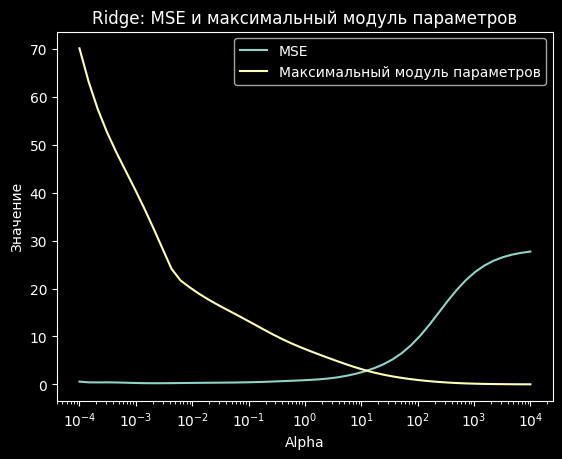

In [96]:
plt.plot(df_ridge_results['Alpha'], df_ridge_results['MSE'], label='MSE')
plt.plot(df_ridge_results['Alpha'], df_ridge_results['Максимальный модуль параметров'], label='Максимальный модуль параметров')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Значение')
plt.title('Ridge: MSE и максимальный модуль параметров')
plt.legend()
plt.show()

### 4. Лассо

In [97]:
def lasso_results_former(pipeline, score, **params):
    return (params['lasso__alpha'], np.max(np.abs(pipeline['lasso'].coef_)), score)

In [98]:
lasso_pipeline = Pipeline([('scaler', MaxAbsScaler()), ('poly', PolynomialFeatures()), ('lasso', Lasso())])

lasso_select_params = ParameterGrid({'poly__degree': np.arange(1, 10 + 1)})

lasso_params = ParameterGrid({'lasso__alpha': np.logspace(-4, 4, 50)})

lasso_selected, lasso_selected_mean_score, lasso_results = run_tests_select(lasso_pipeline, lasso_select_params, lasso_params, X_train, X_test, y_train, y_test, results_former=lasso_results_former)

C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+01, tolerance: 4.017e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.410e+01, tolerance: 4.017e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\USER\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider incre

In [99]:
print(f'Оптимальная степень полинома: {lasso_selected['poly__degree']}\nСреднее MSE: {lasso_selected_mean_score:.5f}')

Оптимальная степень полинома: 6
Среднее MSE: 14.95378


In [100]:
df_lasso_results = pd.DataFrame(lasso_results, columns=['Alpha', 'Максимальный модуль параметров', 'MSE'])

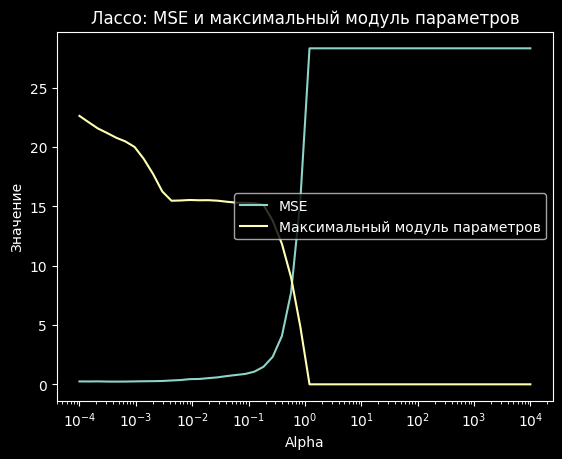

In [101]:
plt.plot(df_lasso_results['Alpha'], df_lasso_results['MSE'], label='MSE')
plt.plot(df_lasso_results['Alpha'], df_lasso_results['Максимальный модуль параметров'], label='Максимальный модуль параметров')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Значение')
plt.title('Лассо: MSE и максимальный модуль параметров')
plt.legend()
plt.show()

### 5. SVR

In [102]:
def svr_results_former(pipeline, score, **params):
    return (params['svr__kernel'], params['svr__C'], f'{params['svr__gamma']}', params['svr__epsilon'], score)

In [103]:
svr_pipeline = Pipeline([('scaler', MaxAbsScaler()), ('svr', SVR())])

svr_params = ParameterGrid({'svr__kernel': ['poly', 'sigmoid']})
svr_optimize_params = {'svr__C': [0.1, 1, 10, 100, 1000, 10000], 'svr__gamma': [0.01, 0.1, 1, 'scale', 'auto'], 'svr__epsilon': [0.01, 0.1, 1]}

svr_selected, svr_selected_mean_score, svr_results = run_tests_optimize(svr_pipeline, svr_params, svr_optimize_params, X_train, X_test, y_train, y_test, results_former=svr_results_former)

In [104]:
print(f'Оптимальная модель SVR:\n\tKernel: {svr_selected['svr__kernel']}\n\tC: {svr_selected['svr__C']}\n\tgamma: {svr_selected['svr__gamma']}\n\tepsilon: {svr_selected['svr__epsilon']}\nMSE: {lasso_selected_mean_score:.5f}')

Оптимальная модель SVR:
	Kernel: sigmoid
	C: 10000
	gamma: 0.01
	epsilon: 1
MSE: 14.95378


In [105]:
df_svr_results = pd.DataFrame(svr_results, columns=['Функция ядра', 'C', 'gamma', 'epsilon', 'MSE'])

df_svr_results

,Функция ядра,C,gamma,epsilon,MSE
0,poly,10000,1,1,3.343103
1,sigmoid,10000,0.01,1,2.959684
